# Skin cancer detection
## Data exploration

First we need to understand the kind of data we have as training data. Common data exploration tasks can be:
* Number of files
* Number of classes
* Class distribution
* Duplicates
* Wrong/missing labels

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [10]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc,roc_curve
import os
from glob import glob
from skimage.io import imread
import shutil

#### LABELS

Excerpts from the paper:

> The HAM10000 Dataset: A Large Collection of Multi-Source Dermatoscopic Images of Common Pigmented Skin Lesions
https://arxiv.org/abs/1803.10417

**nv**  
Melanocytic nevi are benign neoplasms of melanocytes and appear in a myriad of variants, which all are included in our series. The variants may differ significantly from a dermatoscopic point of view.  
*[6705 images]*

**mel**  
Melanoma is a malignant neoplasm derived from melanocytes that may appear in different variants. If excised in an early stage it can be cured by simple surgical excision. Melanomas can be invasive or non-invasive (in situ). We included all variants of melanoma including melanoma in situ, but did exclude non-pigmented, subungual, ocular or mucosal melanoma.  
*[1113 images]*

**bkl**  
"Benign keratosis" is a generic class that includes seborrheic ker- atoses ("senile wart"), solar lentigo - which can be regarded a flat variant of seborrheic keratosis - and lichen-planus like keratoses (LPLK), which corresponds to a seborrheic keratosis or a solar lentigo with inflammation and regression [22]. The three subgroups may look different dermatoscop- ically, but we grouped them together because they are similar biologically and often reported under the same generic term histopathologically. From a dermatoscopic view, lichen planus-like keratoses are especially challeng- ing because they can show morphologic features mimicking melanoma [23] and are often biopsied or excised for diagnostic reasons.  
*[1099 images]*

**bcc**  
Basal cell carcinoma is a common variant of epithelial skin cancer that rarely metastasizes but grows destructively if untreated. It appears in different morphologic variants (flat, nodular, pigmented, cystic, etc) [21], which are all included in this set.  
*[514 images]*

**akiec**  
Actinic Keratoses (Solar Keratoses) and intraepithelial Carcinoma (Bowen’s disease) are common non-invasive, variants of squamous cell car- cinoma that can be treated locally without surgery. Some authors regard them as precursors of squamous cell carcinomas and not as actual carci- nomas. There is, however, agreement that these lesions may progress to invasive squamous cell carcinoma - which is usually not pigmented. Both neoplasms commonly show surface scaling and commonly are devoid of pigment. Actinic keratoses are more common on the face and Bowen’s disease is more common on other body sites. Because both types are in- duced by UV-light the surrounding skin is usually typified by severe sun damaged except in cases of Bowen’s disease that are caused by human papilloma virus infection and not by UV. Pigmented variants exists for Bowen’s disease [19] and for actinic keratoses [20]. Both are included in this set.  
*[327 images]*

**vasc**  
Vascular skin lesions in the dataset range from cherry angiomas to angiokeratomas [25] and pyogenic granulomas [26]. Hemorrhage is also included in this category.  
*[142 images]*

**df**  
Dermatofibroma is a benign skin lesion regarded as either a benign proliferation or an inflammatory reaction to minimal trauma. It is brown often showing a central zone of fibrosis dermatoscopically [24].  
*[115 images]*


*[Total images = 10015]*

### First glance at the availble raw data
#### Specify some paths

In [154]:
raw_dir = '../data/raw/'
interim_dir = '../data/interim'
processed_dir = '../data/processed'
reports_dir = '../reports'
model_dir = '../../models'

#### Check what files we have

In [34]:
os.listdir(raw_dir)

['meta_df.pkl',
 'HAM10000_images_part_1.zip',
 'hmnist_28_28_RGB.csv',
 'HAM10000_metadata.csv',
 'HAM10000_images_part_2.zip',
 'hmnist_28_28_L.csv',
 'HAM10000_images_part_2',
 'skin-cancer-mnist-ham10000.zip',
 'hmnist_8_8_RGB.csv',
 'hmnist_8_8_L.csv',
 'filtered_df.pkl',
 'HAM10000_images_part_1']

* the metadata with all necessary informations are saved in HAM10000_metadata.csv
* the folders HAM10000_images_part_1 and HAM10000_images_part_2 contain the image data

#### Check how the metadata for the images looks

In [35]:
meta_df = pd.read_csv(os.path.join(raw_dir, 'HAM10000_metadata.csv')).set_index('image_id')
meta_df.head(3)

,lesion_id,dx,dx_type,age,sex,localization
image_id,,,,,,
ISIC_0027419,HAM_0000118,bkl,histo,80.0,male,scalp
ISIC_0025030,HAM_0000118,bkl,histo,80.0,male,scalp
ISIC_0026769,HAM_0002730,bkl,histo,80.0,male,scalp


In [36]:
meta_df.describe(exclude=[np.number])

,lesion_id,dx,dx_type,sex,localization
count,10015,10015,10015,10015,10015
unique,7470,7,4,3,15
top,HAM_0005263,nv,histo,male,back
freq,6,6705,5340,5406,2192


It looks like we have duplicates in the lesion_id field. This means we have two pictures for the same lesion. We should remove those duplicates to keep the data more balanced.

Additionally, we can see that we have 7 classes. After looking at the HAM10000 description we find out that the classes are:

In [37]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

#### Lets extend the dataframe with the additional information on the lesion

In [38]:
meta_df['lesion'] = meta_df['dx'].map(lesion_type_dict.get) 
meta_df['lesion_idx'] = pd.Categorical(meta_df['lesion']).codes
meta_df.head(3)

,lesion_id,dx,dx_type,age,sex,localization,lesion,lesion_idx
image_id,,,,,,,,
ISIC_0027419,HAM_0000118,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
ISIC_0025030,HAM_0000118,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
ISIC_0026769,HAM_0002730,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2


#### Class distribution over all images

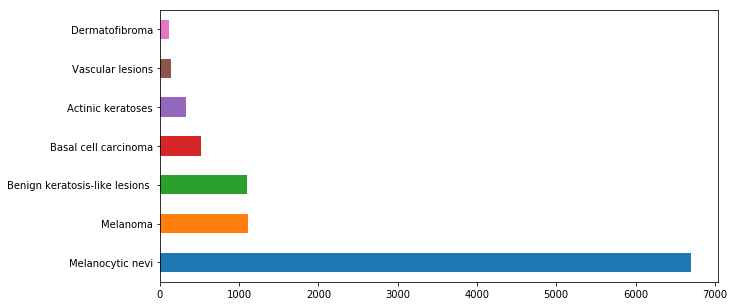

In [39]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
meta_df['lesion'].value_counts().plot(kind='barh', ax=ax1)

Impressions we get from looking at the plot:
* Huge class imbalance in the data   
  This is potentially harmful for the recognition because it will make it more likely for the model to detect the "Melanocytic nevi" class over others.

#### Check how many image files we have and what the shapes are

In [40]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x 
                     for x in glob(os.path.join(raw_dir, '*', '*.jpg'))}

meta_df['path'] = meta_df.index.map(imageid_path_dict.get)
meta_df['lesion_idx'] = pd.Categorical(meta_df['lesion']).codes
meta_df['image'] = meta_df['path'].map(imread)
meta_df['image'].map(lambda x: x.shape).value_counts()

(450, 600, 3)    10015
Name: image, dtype: int64

We can see that all images have the same shape, which allows us to continue with this data without having to reshape the images first.

#### Look at some example picture of each class

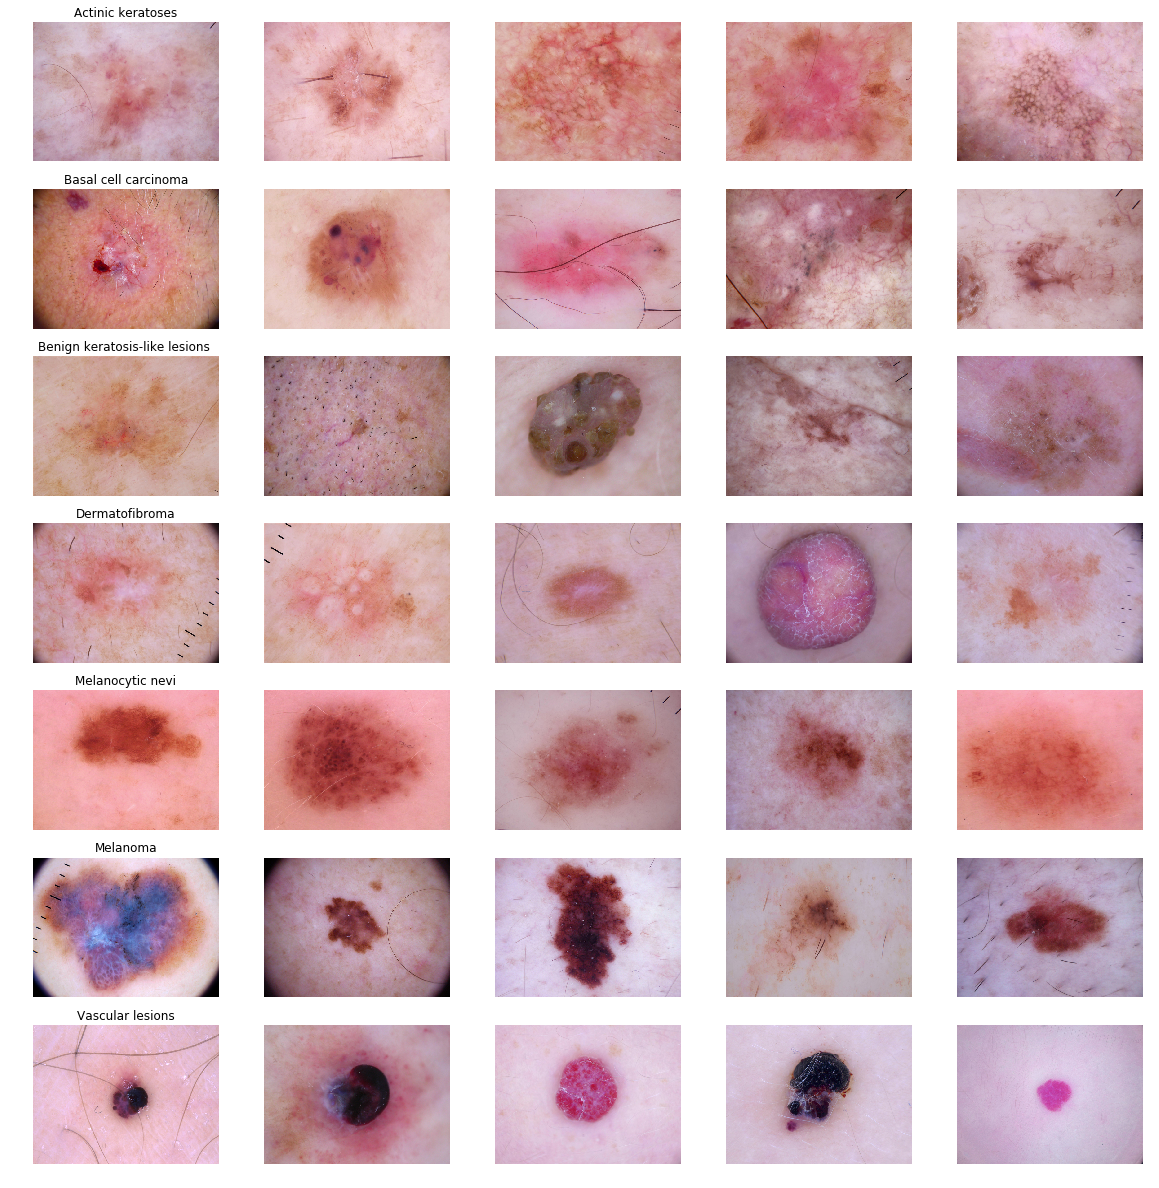

In [41]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         meta_df.sort_values(['lesion']).groupby('lesion')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig(os.path.join(reports_dir, 'category_samples.png'), dpi=300)

#### Save dataframe

In [42]:
meta_df = meta_df.drop('image', axis=1)

In [43]:
meta_df.to_pickle(os.path.join(interim_dir, 'meta_df.pkl'))
os.listdir(base_dir)

['meta_df.pkl',
 'HAM10000_images_part_1.zip',
 'hmnist_28_28_RGB.csv',
 'HAM10000_metadata.csv',
 'HAM10000_images_part_2.zip',
 'hmnist_28_28_L.csv',
 'HAM10000_images_part_2',
 'skin-cancer-mnist-ham10000.zip',
 'hmnist_8_8_RGB.csv',
 'hmnist_8_8_L.csv',
 'filtered_df.pkl',
 'HAM10000_images_part_1']

## Data manipulation & Training data generation

#### Remove duplicates

In [44]:
meta_df.reset_index(inplace=True)
meta_df.describe(exclude=[np.number])

,image_id,lesion_id,dx,dx_type,sex,localization,lesion,path
count,10015,10015,10015,10015,10015,10015,10015,10015
unique,10015,7470,7,4,3,15,7,10015
top,ISIC_0027154,HAM_0005263,nv,histo,male,back,Melanocytic nevi,../data/raw/HAM10000_images_part_1/ISIC_002884...
freq,1,6,6705,5340,5406,2192,6705,1


In [45]:
# create a stratified set
df = meta_df.groupby('lesion_id').count()
# get all images that have only one lesion id
df = df[df['image_id'] == 1]
df.reset_index(inplace=True)

filtered_df = meta_df[meta_df['lesion_id'].isin(df['lesion_id'])]
filtered_df.describe(exclude=[np.number])

,image_id,lesion_id,dx,dx_type,sex,localization,lesion,path
count,5514,5514,5514,5514,5514,5514,5514,5514
unique,5514,5514,7,4,3,15,7,5514
top,ISIC_0028521,HAM_0006424,nv,follow_up,male,lower extremity,Melanocytic nevi,../data/raw/HAM10000_images_part_1/ISIC_002697...
freq,1,1,4415,3704,2907,1228,4415,1


#### Save filtered df

In [47]:
filtered_df.to_pickle(os.path.join(interim_dir, 'filtered_df.pkl'))
os.listdir(interim_dir)

['meta_df.pkl', 'filtered_df.pkl']

#### Load filtered df

In [84]:
filtered_df = pd.read_pickle(os.path.join(interim_dir, 'filtered_df.pkl'))
filtered_df = filtered_df.set_index('image_id')
filtered_df.head()

,lesion_id,dx,dx_type,age,sex,localization,lesion,lesion_idx,path
image_id,,,,,,,,,
ISIC_0025276,HAM_0001396,bkl,histo,55.0,female,trunk,Benign keratosis-like lesions,2,../data/raw/HAM10000_images_part_1/ISIC_002527...
ISIC_0031326,HAM_0007207,bkl,histo,65.0,male,back,Benign keratosis-like lesions,2,../data/raw/HAM10000_images_part_2/ISIC_003132...
ISIC_0032343,HAM_0006071,bkl,histo,70.0,female,face,Benign keratosis-like lesions,2,../data/raw/HAM10000_images_part_2/ISIC_003234...
ISIC_0024981,HAM_0005612,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,../data/raw/HAM10000_images_part_1/ISIC_002498...
ISIC_0027815,HAM_0005388,bkl,histo,80.0,male,chest,Benign keratosis-like lesions,2,../data/raw/HAM10000_images_part_1/ISIC_002781...


#### Get training data

In [92]:
for index, row in filtered_df.iterrows():
    dest = os.path.join(processed_dir, row['dx'])
    if not os.path.exists(dest):
        os.mkdir(dest)
    shutil.copy2(row['path'], dest)

In [100]:
def get_data(bs, size):
    return (ImageItemList.from_folder(processed_dir) 
        .random_split_by_pct(0.15) 
        .label_from_folder() 
        .transform(tfms=get_transforms(flip_vert=True), size=size) 
        .databunch(num_workers=4, bs=bs)
        .normalize(imagenet_stats))

In [104]:
data = get_data(10, 224)
print(data.classes)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


## Model training

In [155]:
learner = create_cnn(data,models.resnet50,metrics=[accuracy], model_dir=model_dir)

In [156]:
learner.loss_func=nn.CrossEntropyLoss()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


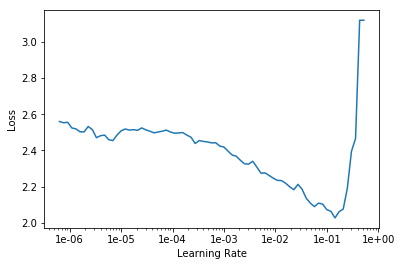

In [157]:
learner.lr_find()
learner.recorder.plot()

In [158]:
learner.fit_one_cycle(8, 3e-3)

epoch,train_loss,valid_loss,accuracy
1,0.556403,0.581841,0.828295
2,0.543856,0.462657,0.850060
3,0.516642,0.522940,0.814994
4,0.446413,0.379656,0.877872
5,0.452661,0.359945,0.879081
6,0.367296,0.319169,0.888755
7,0.308109,0.303935,0.905683
8,0.337914,0.309586,0.903265


In [159]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


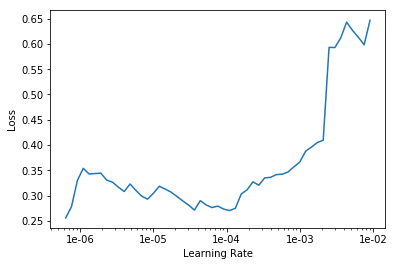

In [160]:
learner.lr_find()
learner.recorder.plot()

In [161]:
lr=1e-6
learner.fit_one_cycle(3, slice(3*lr,10*lr))

epoch,train_loss,valid_loss,accuracy
1,0.277892,0.291329,0.914147
2,0.327019,0.339136,0.889964
3,0.275094,0.300212,0.906892


In [162]:
learner.save('stage-1')

In [163]:
interp = ClassificationInterpretation.from_learner(learner)

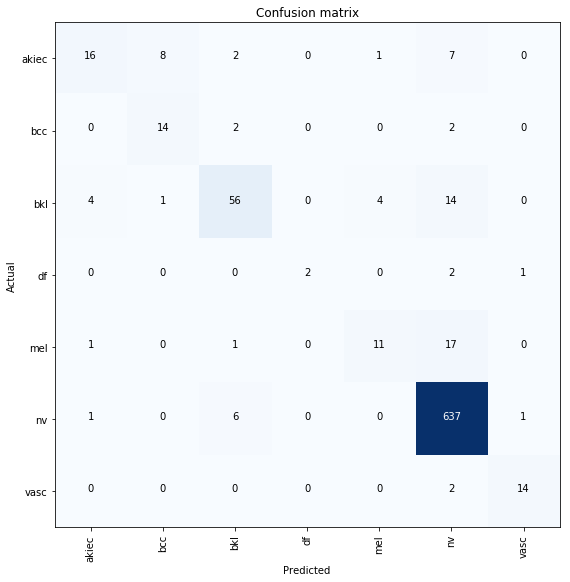

In [164]:
interp.plot_confusion_matrix(figsize=(10,8))

In [135]:
interp.most_confused()

[('bkl', 'nv', 25),
 ('mel', 'nv', 14),
 ('akiec', 'bcc', 8),
 ('akiec', 'nv', 5),
 ('bkl', 'mel', 4),
 ('akiec', 'bkl', 3),
 ('bcc', 'nv', 3),
 ('nv', 'bkl', 3),
 ('df', 'nv', 2),
 ('mel', 'akiec', 2),
 ('vasc', 'nv', 2)]

#### Interference

In [139]:
pred_data=get_data(16,224)

In [142]:
pred_data.classes=list(np.unique(filtered_df.lesion))  
pred_data.c= len(np.unique(filtered_df.lesion)) 
pred_data.single_from_classes(path, pred_data.classes)

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/data_block.py:388: UserWarning: Your training set is empty. Is this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. Is this is by design, pass `ignore_empty=True` to remove this warning.")
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/data_block.py:391: UserWarning: Your validation set is empty. Is this is by design, use `no_split()` 
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


ImageDataBunch;

Train: LabelList
y: CategoryList (0 items)
[]...
Path: dx
x: ImageItemList (0 items)
[]...
Path: dx;

Valid: LabelList
y: CategoryList (0 items)
[]...
Path: dx
x: ImageItemList (0 items)
[]...
Path: dx;

Test: None

In [143]:
predictor = create_cnn(pred_data, models.resnet50, model_dir=model_dir).load('stage-1')

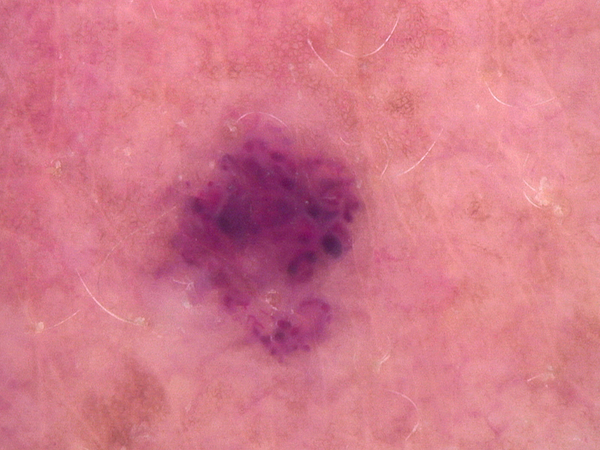

In [152]:
img = open_image(os.path.join(processed_dir, 'vasc', 'ISIC_0031215.jpg'))
img

In [153]:
pred_class,pred_idx,outputs = predictor.predict(img)
pred_class

Category vasc

#### Heatmap

Category nv

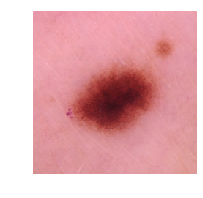

In [146]:
x,y = data.valid_ds[2]
x.show()
data.valid_ds.y[2]

In [147]:
def heatMap(x,y,data, learner, size=(0,224,224,0)):
    """HeatMap"""
    
    # Evaluation mode
    m=learner.model.eval()
    
    # Denormalize the image
    xb,_ = data.one_item(x)
    xb_im = Image(data.denorm(xb)[0])
    xb = xb.cuda()
    
    # hook the activations
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(y)].backward()

    # Activations    
    acts=hook_a.stored[0].cpu()
    
    # Avg of the activations
    avg_acts=acts.mean(0)
    
    # Show HeatMap
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(avg_acts, alpha=0.6, extent=size,
              interpolation='bilinear', cmap='magma')
    

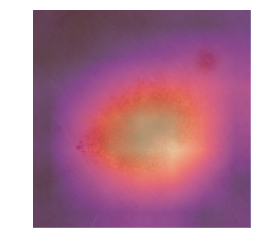

In [148]:
heatMap(x,y,pred_data,learner)